In [1]:
import numpy as np
import heapq
from operator import itemgetter
import numpy.linalg as LA
import xml.etree.ElementTree as et, pandas as pd, re
from bs4 import BeautifulSoup
import gensim
from markdown import markdown
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
xtree = et.parse('Posts.xml')

xroot = xtree.getroot()

dfCols = ["Closed Date", "Favorite Count", "Comment Count", "Answer Count", "Tags", "Title",
          "Last Activity Date", "Owner User ID", "Body", "View Count", "Score", "Creation Date", "Post Type ID", 
          "ID", "Parent ID", "Last Edit Date", "Last Editor User ID", "Accepted Answer ID"]
dfRows = []

In [3]:
for node in xroot:
    closedDate = node.attrib.get("ClosedDate")
    favCount = node.attrib.get("FavoriteCount")
    commentCount = node.attrib.get("CommentCount")
    ansCount = node.attrib.get("AnswerCount")
    tags = node.attrib.get("Tags")
    title = node.attrib.get("Title")
    lastActDate = node.attrib.get("LastActivityDate")
    ownerUserID = node.attrib.get("OwnerUserId")
    body = node.attrib.get("Body")
    viewCount = node.attrib.get("ViewCount") 
    score = node.attrib.get("Score") 
    creationDate = node.attrib.get("CreationDate") 
    postTypeID = node.attrib.get("PostTypeId") 
    ID = node.attrib.get("Id") 
    parentID = node.attrib.get("ParentId") 
    lastEditDate = node.attrib.get("LastEditDate") 
    lastEditorUserID = node.attrib.get("LastEditorUserId") 
    acceptedAnswerID = node.attrib.get("AcceptedAnswerID")
    
    dfRows.append({"Closed Date": closedDate, "Favorite Count": favCount, "Comment Count": commentCount,
                     "Answer Count": ansCount, "Tags": tags, "Title": title, "Last Activity Date": lastActDate,
                     "Owner User ID": ownerUserID, "Body": body, "View Count": viewCount, "Score": score, 
                    "Creation Date": creationDate, "Post Type ID": postTypeID, "ID": ID, "Parent ID": parentID,
                    "Last Edit Date": lastEditDate, "Last Editor User ID": lastEditorUserID, "Accepted Answer ID": acceptedAnswerID})

In [4]:
out = pd.DataFrame(dfRows, columns=dfCols)

out = out.fillna(0)

out['Creation Date'] = pd.to_datetime(out['Creation Date'])
out['Creation Date'] = out['Creation Date'].dt.strftime('%Y/%m/%d')
out['Comment Count'] = out['Comment Count'].astype(int)
out['Owner User ID'] = out['Owner User ID'].astype(int)
out['Post Type ID'] = out['Post Type ID'].astype(int)
out['Score'] = out['Score'].astype(int)
out['Favorite Count'] = out['Favorite Count'].astype(int)
out['Answer Count'] = out['Answer Count'].astype(int)
out['View Count'] = out['View Count'].astype(int)

answers = out[(out['Post Type ID'] == 1)]

answers = answers[['ID','Creation Date','Tags','Title','Body']]

#words kolonu title ile bodynin birleşmiş hali, 
answers['Words'] = answers[['Title', 'Body', 'Tags']].apply(lambda x: ' '.join(x), axis=1)

answers['Words'].apply(lambda x: ''.join(BeautifulSoup(markdown(x)).findAll(text=True)))
answers.head

<bound method NDFrame.head of           ID Creation Date                                               Tags  \
0          1    2016/08/02  <neural-networks><backpropagation><terminology...   
1          2    2016/08/02  <neural-networks><machine-learning><statistica...   
3          4    2016/08/02                    <deep-network><search><neurons>   
4          5    2016/08/02                               <python><mindstorms>   
5          6    2016/08/02       <philosophy><definitions><intelligent-agent>   
6          7    2016/08/02                                <intelligent-agent>   
9         10    2016/08/02           <deep-network><terminology><fuzzy-logic>   
12        13    2016/08/02               <neural-networks><image-recognition>   
14        15    2016/08/02  <turing-test><strong-ai><intelligent-agent><we...   
15        16    2016/08/02  <deep-learning><definitions><overfitting><regu...   
16        17    2016/08/02  <philosophy><definitions><agi><superintelligen...  

In [9]:
size = len(answers['ID'].to_list())

In [6]:
id_set = answers.ID.to_list() #Documents

In [7]:
def read_corpus(fname, tokens_only=False):
    for i, line in enumerate(fname):
        tokens = gensim.utils.simple_preprocess(line)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [int(id_set[i])])

In [8]:
trainData =answers['Words'].tolist()#[:4068]
testData =answers['Words'].tolist()[4068:]
tags = dict(zip(answers.ID.astype(int), answers.Tags))

In [9]:
train_corpus = list(read_corpus(trainData))
test_corpus = list(read_corpus(testData, tokens_only=True))

In [10]:
idTextDict = dict(zip(answers.ID, answers.Words))

In [11]:
model = gensim.models.doc2vec.Doc2Vec(min_count=1,window=5,vector_size=300,workers=5,alpha=0.025,min_alpha=0.00025,dm=1, epochs = 50)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [12]:
model.save("CQA_FRONTEND/static/data/doc2vecmodel")

In [13]:
doc_id = id_set.index("14119")
print(doc_id)
inferred_vector = model.infer_vector(test_corpus[doc_id-4068])
sims = model.docvecs.most_similar([inferred_vector], topn=100)
print(id_set[id_set.index("14119")])

4329
14119


In [14]:
print(id_set.index("13425"))
id_set[id_set.index("13425")]

4041


'13425'

In [15]:
for (item,val) in sims:
    print(item, val)

14119 0.9434587359428406
5274 0.38888418674468994
8854 0.35044777393341064
7573 0.34923845529556274
15932 0.3381182849407196
7926 0.33374840021133423
12593 0.33206385374069214
6125 0.32768332958221436
2111 0.32725396752357483
5258 0.32558542490005493
1289 0.3227015733718872
12441 0.3175404667854309
6 0.3173747956752777
3537 0.3169791102409363
13398 0.3154621124267578
1897 0.31169891357421875
6161 0.31069880723953247
1376 0.30901509523391724
13866 0.3085135221481323
2066 0.30725744366645813
3832 0.3057921230792999
15449 0.30516278743743896
1853 0.30514293909072876
1648 0.3042663335800171
15668 0.3039546310901642
3683 0.3025151491165161
3950 0.30250370502471924
9924 0.3013642430305481
9033 0.300932377576828
2578 0.3006870150566101
17939 0.3001002371311188
6214 0.29955363273620605
9010 0.2994251847267151
11208 0.2985054850578308
2048 0.2981087565422058
16291 0.29802748560905457
1501 0.29775315523147583
80 0.2976980209350586
15713 0.29669710993766785
6584 0.2964409589767456
1420 0.29611939

In [16]:
cosineResultDict = {}
for i in range(0, len(test_corpus)):
    inferred_vector = model.infer_vector(test_corpus[i])
    sims = model.docvecs.most_similar([inferred_vector], topn=100)
    cosineResultDict[int(id_set[4068+i])] = sims 

In [17]:
#osineResultDict["4041"]

In [18]:
relatedId = {}
with open("CQA_FRONTEND/static/data/relatedFrom13425_test.txt") as f:
    for line in f:
        (key, val) = line.split(",")
        relatedId[int(key)] = [int(i) for i in val.strip().split()]
relatedId

{13425: [8828, 54, 8594, 7446, 7838, 3176, 12991, 11523],
 13426: [18081, 17948, 15999, 13343, 10839, 6318],
 13429: [17530, 15910, 13968, 12268, 11878, 10719, 9829, 7580, 4984],
 13432: [17775, 13907, 16120, 2524, 7273, 3453, 4421],
 13434: [18232, 1742, 17002, 16384, 8637, 11152, 4576],
 13435: [17629, 2381, 12433, 12086, 3298, 6115, 4139, 3702],
 13436: [9504, 11119, 7518, 7417],
 13437: [16322, 16131, 12255, 10586, 9590, 5332],
 13443: [15562, 12897, 12021, 10145, 8580, 5836, 4131, 5208, 2793],
 13444: [10053, 12397, 16443, 13531, 11513, 11593, 9937],
 13448: [10556, 2127, 1946, 1488, 12116, 4764, 3457, 1318],
 13449: [5904, 17094, 16171, 3469, 10734, 5855],
 13450: [16447, 16564, 13156],
 13451: [17160, 12734, 2911, 12954, 5928],
 13454: [17004, 13975, 13573, 13549, 5769, 12649, 12366, 8929, 7949],
 13457: [9197, 11679, 15918, 13147, 12053, 8128, 7707, 5454],
 13460: [15408, 2598, 6975, 6741, 5114, 2672],
 13464: [17108, 4085, 7685, 8212, 7832, 7408],
 13466: [17619, 12469, 12408,

In [19]:
crossCheckDict = {}
bothRelatedAndSim = {}
for key in cosineResultDict.keys():
    counter = 0
    if key in relatedId.keys():
        for rel in relatedId[key]:
            for (simId,sim) in cosineResultDict[key]:
                if rel == simId:
                    if key in bothRelatedAndSim.keys():
                        bothRelatedAndSim[key].append((simId,sim))
                    else:
                        bothRelatedAndSim[key] = [(simId,sim)]

                    counter += 1
    crossCheckDict[key] = counter


In [20]:
crossCheckDict

{13487: 0,
 13489: 1,
 13494: 0,
 13495: 2,
 13498: 1,
 13499: 1,
 13502: 3,
 13503: 0,
 13504: 1,
 13507: 2,
 13508: 2,
 13510: 0,
 13515: 2,
 13516: 0,
 13518: 0,
 13522: 4,
 13523: 1,
 13524: 3,
 13526: 1,
 13527: 1,
 13529: 3,
 13531: 3,
 13538: 1,
 13540: 2,
 13544: 2,
 13545: 2,
 13549: 3,
 13550: 2,
 13551: 1,
 13552: 4,
 13554: 2,
 13555: 2,
 13556: 0,
 13557: 3,
 13560: 2,
 13562: 1,
 13566: 1,
 13567: 3,
 13568: 1,
 13570: 1,
 13572: 1,
 13573: 7,
 13575: 0,
 13576: 0,
 13577: 1,
 13580: 3,
 13593: 3,
 13595: 1,
 13596: 0,
 13600: 2,
 13603: 0,
 13604: 3,
 13605: 1,
 13607: 0,
 13612: 1,
 13613: 1,
 13615: 0,
 13617: 3,
 13619: 1,
 13620: 1,
 13622: 0,
 13627: 3,
 13630: 0,
 13631: 2,
 13633: 0,
 13641: 0,
 13642: 1,
 13643: 2,
 13644: 1,
 13645: 0,
 13646: 1,
 13647: 1,
 13648: 0,
 13650: 0,
 13651: 0,
 13654: 0,
 13656: 0,
 13657: 1,
 13660: 2,
 13662: 1,
 13663: 0,
 13666: 0,
 13668: 5,
 13669: 2,
 13671: 2,
 13683: 0,
 13689: 1,
 13691: 0,
 13692: 1,
 13693: 0,
 13694: 2,

Contextwise, our doc2vec model returns better results than stack exchange's related questions. Sometimes stack exchange doesn't suggest any related results even though there is still similar questions our there that we found. The ones that stack exchange thinks they are related are only the ones with matching 2-3 words at most in whole paragraph and similar tags in general. (example ids, 14173, 14204,13849)

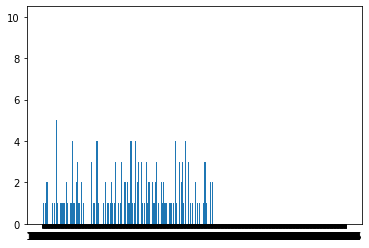

In [21]:
plt.bar(range(len(crossCheckDict)), list(crossCheckDict.values()), align='center')
plt.xticks(range(len(crossCheckDict)), list(crossCheckDict.keys()))
plt.show()

In [22]:
listOfVals = crossCheckDict.values()

In [23]:
len(listOfVals)

1737

In [24]:
sum(listOfVals)/len(listOfVals)

0.6833621185952792

In [25]:
sum(listOfVals)

1187

In [26]:
for key in bothRelatedAndSim.keys():
    print("https://ai.stackexchange.com/questions/" + str(key))
    print([i for i,j in bothRelatedAndSim[key]])

https://ai.stackexchange.com/questions/13489
[15422]
https://ai.stackexchange.com/questions/13495
[247, 4320]
https://ai.stackexchange.com/questions/13498
[18082]
https://ai.stackexchange.com/questions/13499
[13544]
https://ai.stackexchange.com/questions/13502
[13307, 12270, 10422]
https://ai.stackexchange.com/questions/13504
[3081]
https://ai.stackexchange.com/questions/13507
[8716, 7511]
https://ai.stackexchange.com/questions/13508
[18187, 13317]
https://ai.stackexchange.com/questions/13515
[5539, 8016]
https://ai.stackexchange.com/questions/13522
[12671, 10158, 7367, 5093]
https://ai.stackexchange.com/questions/13523
[13575]
https://ai.stackexchange.com/questions/13524
[13544, 11847, 9278]
https://ai.stackexchange.com/questions/13526
[13470]
https://ai.stackexchange.com/questions/13527
[13641]
https://ai.stackexchange.com/questions/13529
[13148, 13152, 11347]
https://ai.stackexchange.com/questions/13531
[12397, 16441, 9624]
https://ai.stackexchange.com/questions/13538
[2462]
https:/

In [27]:
f = open("DOC2VEC_RELATEDDICT.txt", "a")
for key in bothRelatedAndSim:  
    f.write(str(key)+"\t"+str([i for i,j in bothRelatedAndSim[key]])+"\n")
f.close()

In [28]:
for key in crossCheckDict.keys():
    if crossCheckDict[key] == 0:
        print("https://ai.stackexchange.com/questions/" + str(key))


https://ai.stackexchange.com/questions/13487
https://ai.stackexchange.com/questions/13494
https://ai.stackexchange.com/questions/13503
https://ai.stackexchange.com/questions/13510
https://ai.stackexchange.com/questions/13516
https://ai.stackexchange.com/questions/13518
https://ai.stackexchange.com/questions/13556
https://ai.stackexchange.com/questions/13575
https://ai.stackexchange.com/questions/13576
https://ai.stackexchange.com/questions/13596
https://ai.stackexchange.com/questions/13603
https://ai.stackexchange.com/questions/13607
https://ai.stackexchange.com/questions/13615
https://ai.stackexchange.com/questions/13622
https://ai.stackexchange.com/questions/13630
https://ai.stackexchange.com/questions/13633
https://ai.stackexchange.com/questions/13641
https://ai.stackexchange.com/questions/13645
https://ai.stackexchange.com/questions/13648
https://ai.stackexchange.com/questions/13650
https://ai.stackexchange.com/questions/13651
https://ai.stackexchange.com/questions/13654
https://ai

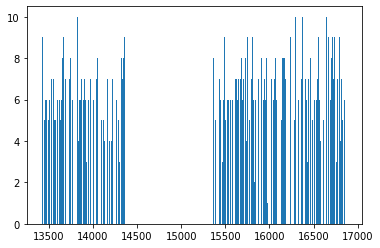

In [29]:
x = relatedId.keys()
bins = []

for key in x:
    bins.append(len(relatedId[key]))

width = bins[1] - bins[0]
plt.bar(x, bins, align='center', width=width)
plt.show()


In [30]:
tags[1]

'<neural-networks><backpropagation><terminology><definitions>'

In [31]:
for key in tags.keys():
    s = tags[key].replace("<", "", len(tags[key]))
    s = s.replace(">", " ", len(tags[key]))
    tags[key] = s.strip().split(" ")


Example tags for a questions and for its related ones.

In [32]:
key = 13544
print(key, relatedId[key])
print(tags[key])
for item in relatedId[key]:
    if item in tags.keys():
        print(item, tags[item])

13544 [4376, 8518, 2817, 12671, 8962, 6139]
['neural-networks', 'recurrent-neural-networks', 'optimization', 'logic', 'function-approximation']
4376 ['neural-networks', 'comparison', 'function-approximation', 'learning-theory']
8518 ['neural-networks', 'machine-learning', 'backpropagation']
2817 ['optimization', 'heuristics']
12671 ['neural-networks', 'function-approximation']
8962 ['machine-learning', 'backpropagation', 'terminology', 'optimization']
6139 ['neural-networks', 'ai-design', 'optimization']


In [33]:
tagVsQuestion = {}
for key in relatedId.keys():
    #print(key, relatedId[key])
    #print(tags[key])
    true = 0
    false = 0
    for item in relatedId[key]:
        if item in tags.keys():
            #print(item, tags[item])
            #print(np.in1d(tags[key],tags[item]).any())
            if np.in1d(tags[key],tags[item]).any():
                true += 1
            else:
                false += 0
            if true+false == 0:
                tagVsQuestion[key] = 0
            else:
                print(true,false)
                tagVsQuestion[key] = float(true /(true+false))
        else:
            tagVsQuestion[key] = 0


1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
1 0
2 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0


2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0


KeyError: 15691

In [34]:
tagVsQuestion[13425]

1.0

In [35]:
print([x for x in tagVsQuestion.keys() if tagVsQuestion[x] == 0])

[]
